## Advanced Data Analysis and Machine Learning
### Workshop 10.11.2025 - RNN
Author: Eetu Knutars

Importing the libraries required for the solutions. I use `PyTorch` framework as the basis for my RNN model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eknut\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Loading the data and tokenizing the text values using the `word_tokenize` function from `nltk` library.

In [2]:
# Loading dataset into a pandas dataframe
df = pd.read_csv(
    "df_file.csv",
    quotechar='"',     # some additional parameters used here to make sure the data is read correctly
    escapechar='\\',   
    engine='python'    
)

# Encoding the labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Tokenize the text
df['Tokens'] = df['Text'].apply(lambda x: word_tokenize(str(x).lower()))

# Using 70/15/15 split for train/validation/test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])

Defining the vocabulary by processing all words in the train set

In [3]:
all_words = [word for tokens in train_df['Tokens'] for word in tokens]
word_counts = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab["<PAD>"] = 0 # padding
vocab["<UNK>"] = 1 # unknown words

# Encoder function using the vocabulary defined by the train set
def encode(tokens):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokens]

Defining a dataset for the data to simplify the data loading for the model

In [4]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.texts = [torch.tensor(encode(tokens), dtype=torch.long) for tokens in df['Tokens']]
        self.labels = torch.tensor(df['Label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<PAD>"])
    return padded_texts, torch.tensor(labels)

Defining the actual RNN model architecture. The model is kept pretty simple, embedding layer converts input tokens into vectors, bidirectional RNN layer is used, then one fully connected layer and dropout layer with 30% dropout rate.

In [5]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)
        # For bidirectional RNNs, hidden has shape [num_layers * 2, batch, hidden_dim]
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

Storing the dataframes (test and train) into loaders

In [6]:
train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)
test_dataset = TextDataset(test_df)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

Initializing the model to be trained. CrossEntropyLoss is used since we are having a classification task, Adam optimizer is used and the learning rate is set to 0.001

In [7]:
vocab_size = len(vocab)
model = RNN(vocab_size, embed_dim=100, hidden_dim=128, output_dim=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RNN(
  (embedding): Embedding(29638, 100, padding_idx=0)
  (rnn): RNN(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Training the model. Early stopping with 3 epoch patience is used to avoid overfitting the model too much.

In [8]:
best_val_loss = float('inf')
patience = 3
patience_counter = 0
best_model_state = None

for epoch in range(10):
    
    model.train()
    train_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation of epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # Early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            model.load_state_dict(best_model_state)
            break

Epoch 1, Train Loss: 1.5805, Val Loss: 1.4986, Val Acc: 36.83%
Epoch 2, Train Loss: 1.3701, Val Loss: 1.3490, Val Acc: 46.41%
Epoch 3, Train Loss: 1.1254, Val Loss: 1.2279, Val Acc: 49.40%
Epoch 4, Train Loss: 0.8466, Val Loss: 1.2155, Val Acc: 51.50%
Epoch 5, Train Loss: 0.6360, Val Loss: 1.1350, Val Acc: 59.58%
Epoch 6, Train Loss: 0.4539, Val Loss: 1.0853, Val Acc: 61.68%
Epoch 7, Train Loss: 0.2916, Val Loss: 1.0725, Val Acc: 64.07%
Epoch 8, Train Loss: 0.1697, Val Loss: 1.0578, Val Acc: 66.77%
Epoch 9, Train Loss: 0.1057, Val Loss: 1.1724, Val Acc: 63.17%
Epoch 10, Train Loss: 0.0834, Val Loss: 1.1717, Val Acc: 66.47%


Model evalutation by classifying all samples in the test set. Visualising the results with accuracy calculation and a confusion matrix.

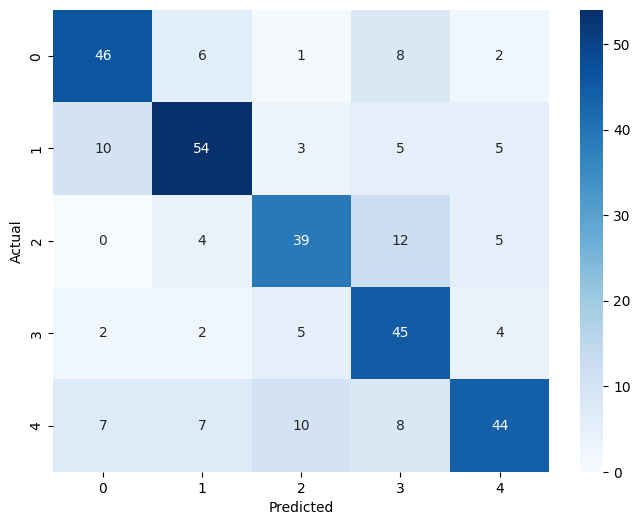

Accuracy: 0.683


In [9]:
model.eval()

# Predictions on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Accuracy: {accuracy:.3f}")